# Розробока власної нейронної мережі

Цей проєкт створено для покращення розуміння того як працюють нейронні мережі. Для розробки використовуються суто структури даних Python.

## Функція активації

Функція активації використовується для використання __нелінійності__ при побудові функції класифікації (або регресії).

Найбільш поширеними функціями активації є:
- Sigmoid
- Tanh
- RelU
- LeakyRelU

Для даної нейронної мережі буде використана функція RelU:

RelU = max(0, x)

In [218]:
def rel_u(x):
    return max(0, x)

In [219]:
rel_u(-1)

0

In [220]:
rel_u(1)

1

In [221]:
rel_u(100)

100

In [222]:
def rel_u_derivative(x):
    return 0 if x <= 0 else 1

In [223]:
rel_u_derivative(0)

0

In [224]:
rel_u_derivative(1)

1

In [225]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [226]:
sigmoid(10000)

1.0

In [227]:
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

In [228]:
sigmoid_derivative(10000)

0.0

In [229]:
sigmoid_derivative(0.5)

0.2350037122015945

## Нейронна мережа

In [238]:
class NeuralNetwork:
    def activation(self, x):
        return sigmoid(x)
    
    def activation_derivative(self, x):
        return sigmoid_derivative(x)
    
    learning_rate = 0.7
    
n = NeuralNetwork()

## Нейрон

Виступає атомарним будівельник блоком нейронної мережі

In [231]:
# TODO:
# Після того як нейронна мережа буде складатись з більш як одного вихідного нейрону,
# потрібно виокремити forward/loss/backward функції до класу Нейронної Мережі
class Neuron:
    def __init__(self, inputs, weights, bias):
        self.inputs = inputs
        self.weights = weights
        self.bias = bias
        
    def output(self):
        result = 0
        for input, weight in zip(self.inputs, self.weights):
            result += input * weight
        result += self.bias
        return result
    
    def set_inputs(self, inputs):
        self.inputs = inputs
        
    def forward(self):
        return n.activation(self.output())
    
    def loss(self, y, y_hat):
        return (y - y_hat)**2
    
    def backward(self, y, y_hat):
        # L = функція визначення помилки
        # d = вираз y - y_hat
        dLdd = 2 * (y - y_hat)
        # y = rel_u(z)
        dddy = 1
        # z = sum (wx + b)
        dydz = n.activation_derivative(self.output())
        dzdw1 = self.inputs[0]
        dzdw2 = self.inputs[1]
        dzdb = 1
        # Диференціювання складної функції
        dLdw1 = dLdd * dddy * dydz * dzdw1
        dLdw2 = dLdd * dddy * dydz * dzdw2
        dLdb = dLdd * dddy * dydz * dzdb
        
        # Виконання задньої пропагації
        
        # w1
        self.weights[0] -= n.learning_rate * dLdw1
        
        # w2
        self.weights[1] -= n.learning_rate * dLdw2
        
        # b
        self.bias -= n.learning_rate * dLdb

## Набір даних

In [232]:
# [length, width, class]
entities_class_1 = [
    [3, 1, 1],
    [2, 2, 1]
]

entities_class_2 = [
    [1, 3, 0],
    [1.5, 2.5, 1]
]

entities = entities_class_1 + entities_class_2

entity_secret = [1.75, 2.25]

## Візуалізація набору даних

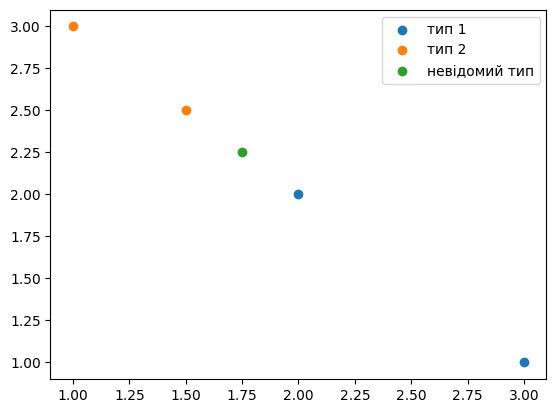

In [233]:
import matplotlib.pyplot as plt

x = list(map(lambda e: e[0], entities_class_1))
y = list(map(lambda e: e[1], entities_class_1))

x2 = list(map(lambda e: e[0], entities_class_2))
y2 = list(map(lambda e: e[1], entities_class_2))

plt.scatter(x, y)
plt.scatter(x2, y2)
plt.scatter(entity_secret[0], entity_secret[1])


plt.legend(['тип 1', 'тип 2', 'невідомий тип'])

plt.show()

## Тренування моделі

### Ініціалізація

In [242]:
import random

neuron = Neuron([], [0.2, 0.7], 0)

plot_data = []

for i in range(1, 3):
    random_entity = random.choice(entities)
    
    neuron.set_inputs([random_entity[0], random_entity[1]])

    print(f'Random entity is of type: {random_entity[2]}')

    print(f'Iteration number: {i}')

    output = neuron.forward()
    print(f'Predicted type is: {output}')
    
    loss = neuron.loss(random_entity[2], output)
    print(f'Calculated Loss: {loss}')

    
    neuron.backward(random_entity[2], output)
    
    plot_data.append([i, loss])

Random entity is of type: 1
Iteration number: 1
Predicted type is: 0.8859476187202091
Calculated Loss: 0.013007945675590797
Random entity is of type: 0
Iteration number: 2
Predicted type is: 0.8946042360510476
Calculated Loss: 0.8003167391604784


### Візуалізація прогресу тренування

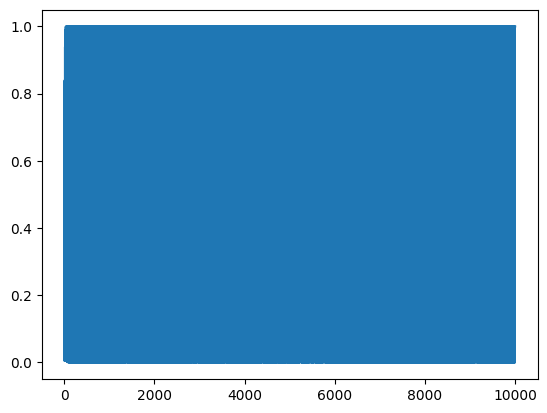

In [240]:
x = list(map(lambda pd: pd[0], plot_data))
y = list(map(lambda pd: pd[1], plot_data))

plt.plot(x, y)

plt.show()

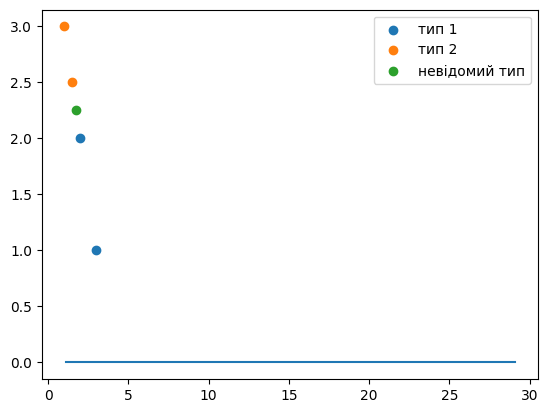

In [236]:
x = list(map(lambda e: e[0], entities_class_1))
y = list(map(lambda e: e[1], entities_class_1))

x2 = list(map(lambda e: e[0], entities_class_2))
y2 = list(map(lambda e: e[1], entities_class_2))

plt.scatter(x, y)
plt.scatter(x2, y2)
plt.scatter(entity_secret[0], entity_secret[1])


plt.legend(['тип 1', 'тип 2', 'невідомий тип'])

xi = 0
yi = 0

x_plot = []
y_plot = []
z_plot = []

for xi in range(1, 30):
    xi += 0.1
    x_plot.append(xi)
    
for yi in range(1, 30):
    yi += 0.1
    y_plot.append(yi)
    
for zi in range(1, 30):
    neuron.set_inputs([xi, yi])
    z_plot.append(neuron.forward())

plt.plot(x_plot, z_plot)

plt.show()